<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#¬øQu√©-es-una-Serie-Temporal?" data-toc-modified-id="¬øQu√©-es-una-Serie-Temporal?-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>¬øQu√© es una Serie Temporal?</a></span></li><li><span><a href="#Exploraci√≥n-de-los-datos" data-toc-modified-id="Exploraci√≥n-de-los-datos-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Exploraci√≥n de los datos</a></span><ul class="toc-item"><li><span><a href="#Conversi√≥n-de-la-columna-month-a-datetime" data-toc-modified-id="Conversi√≥n-de-la-columna-month-a-datetime-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Conversi√≥n de la columna month a datetime</a></span></li><li><span><a href="#Chequeemos-los-nulos." data-toc-modified-id="Chequeemos-los-nulos.-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Chequeemos los nulos.</a></span></li></ul></li><li><span><a href="#Componentes-de-una-Serie-Temporal" data-toc-modified-id="Componentes-de-una-Serie-Temporal-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Componentes de una Serie Temporal</a></span><ul class="toc-item"><li><span><a href="#Estacionalidad" data-toc-modified-id="Estacionalidad-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Estacionalidad</a></span></li><li><span><a href="#Estacionaridad" data-toc-modified-id="Estacionaridad-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Estacionaridad</a></span></li><li><span><a href="#Comparativa-estacionalidad-vs-estacionaridad" data-toc-modified-id="Comparativa-estacionalidad-vs-estacionaridad-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Comparativa estacionalidad vs estacionaridad</a></span></li></ul></li><li><span><a href="#Autocorrelaci√≥n" data-toc-modified-id="Autocorrelaci√≥n-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Autocorrelaci√≥n</a></span></li><li><span><a href="#Modelo-ARMA" data-toc-modified-id="Modelo-ARMA-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Modelo ARMA</a></span></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]


## Para sacar los componentes de la serie temporal
################################################################
from statsmodels.tsa.seasonal import seasonal_decompose


## Para calcular la estacionaridad de nuestras series temporales
################################################################
from statsmodels.tsa.stattools import adfuller

## Para calcular la autocorrelaci√≥n en la serie temporal
################################################################
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

## Para ajustar los modelos predictivos
################################################################
from statsmodels.tsa.arima.model import ARIMA
from itertools import product

## Para las metricas del modelo
################################################################
from sklearn.metrics import mean_squared_error

## Para ignorar los warnings
################################################################
import warnings
warnings.filterwarnings("ignore")


# ¬øQu√© es una Serie Temporal?

Una Serie Temporal, es una sucesi√≥n de datos medidos en determinados momentos y ordenados cronol√≥gicamente. Los datos pueden estar espaciados a intervalos iguales (como la temperatura en un observatorio meteorol√≥gico en d√≠as sucesivos al mediod√≠a) o desiguales (como el peso de una persona en sucesivas mediciones en el consultorio m√©dico, la farmacia, etc.).

Cuando estamos trabajando con Series Temporales nos tenemos que hacer las siguientes preguntas: 

- ¬øEs estacionario?

- ¬øHay una estacionalidad?

- ¬øLos datos est√°n autocorrelacionados?

# Exploraci√≥n de los datos

In [2]:
df = pd.read_csv("data/data2.csv")
df.head()

month  mean_temp
0  1982-01       25.9
1  1982-02       27.1
2  1982-03       27.2
3  1982-04       27.0
4  1982-05       28.0

In [3]:
df.describe().T

count       mean       std   min   25%   50%   75%   max
mean_temp  463.0  27.665659  0.807385  25.4  27.1  27.7  28.3  29.5

## Conversi√≥n de la columna month a datetime
Para trabajar con Series Temporales debemos asegurarnos de que la columna de fecha esta en formato `datetime`, que este como √≠ndice y debe tener alguna frecuencia. Veamos como hacerlo: 

In [4]:
df.dtypes

month         object
mean_temp    float64
dtype: object

In [5]:
# colocamos la columna a datetime y la ponemos como √≠ndice
df.index = pd.to_datetime(df["month"])
df.head()

month  mean_temp
month                         
1982-01-01  1982-01       25.9
1982-02-01  1982-02       27.1
1982-03-01  1982-03       27.2
1982-04-01  1982-04       27.0
1982-05-01  1982-05       28.0

In [6]:
# veamos como es nuestro √≠ndice
df.index

DatetimeIndex(['1982-01-01', '1982-02-01', '1982-03-01', '1982-04-01',
               '1982-05-01', '1982-06-01', '1982-07-01', '1982-08-01',
               '1982-09-01', '1982-10-01',
               ...
               '2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01'],
              dtype='datetime64[ns]', name='month', length=463, freq=None)

Si nos fijamos nuestra columna de momento no tiene frecuencia. Para cambiarlo usaremos el m√©todo `infer_freq` de pandas

In [7]:
df.index.freq = pd.infer_freq(df.index)
df.index

DatetimeIndex(['1982-01-01', '1982-02-01', '1982-03-01', '1982-04-01',
               '1982-05-01', '1982-06-01', '1982-07-01', '1982-08-01',
               '1982-09-01', '1982-10-01',
               ...
               '2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01'],
              dtype='datetime64[ns]', name='month', length=463, freq='MS')

Si nos fijamos ahora Pandas automaticamente ha detectado la frecuencia, es de d√≠a. 

In [8]:
df.head()

month  mean_temp
month                         
1982-01-01  1982-01       25.9
1982-02-01  1982-02       27.1
1982-03-01  1982-03       27.2
1982-04-01  1982-04       27.0
1982-05-01  1982-05       28.0

In [9]:
# por √∫ltimo eliminamos la columna de DATE que ya no nos hace falta. 
df.drop(columns=['month'], inplace=True)
df.head()

mean_temp
month                
1982-01-01       25.9
1982-02-01       27.1
1982-03-01       27.2
1982-04-01       27.0
1982-05-01       28.0

## Chequeemos los nulos. 

üö®üö®üö® No podremos tenere nulos en el *dataframe*

In [10]:
df.isnull().sum()

mean_temp    0
dtype: int64

In [11]:
####################################
#               NOTA
####################################

# en caso de que tengamos nulos podemos usar el m√©todo interpolate

df = df.interpolate(method ='linear')
df.head()

mean_temp
month                
1982-01-01       25.9
1982-02-01       27.1
1982-03-01       27.2
1982-04-01       27.0
1982-05-01       28.0

In [12]:
df.columns = ["valores"]

# Componentes de una Serie Temporal

El an√°lisis cl√°sico de series temporales considera que una serie temporal queda formada por cuatro
componentes:

- `Tendendia o Estacionaridad`: movimiento regular de la serie, a largo plazo.


- `Variaciones estacionales`: oscilaciones a corto plazo del per√≠odo regular, de duraci√≥n menor o igual a un a√±o.


- `Variaciones c√≠clicas`: movimientos a medio plazo (superior a un a√±o) en torno a la tendencia cuyo per√≠odo y amplitud pueden presentar cierta regularidad.


- `Ruido Blanco o residuos`: consisten en movimientos irregulares y pasajeros provocados por factores espor√°dicos e imprevisibles. Son efectos impredecibles que no son asignables a ninguna de las componentes anteriores, por lo que constituyen el residuo que queda cuando se estiman las otras componentes.

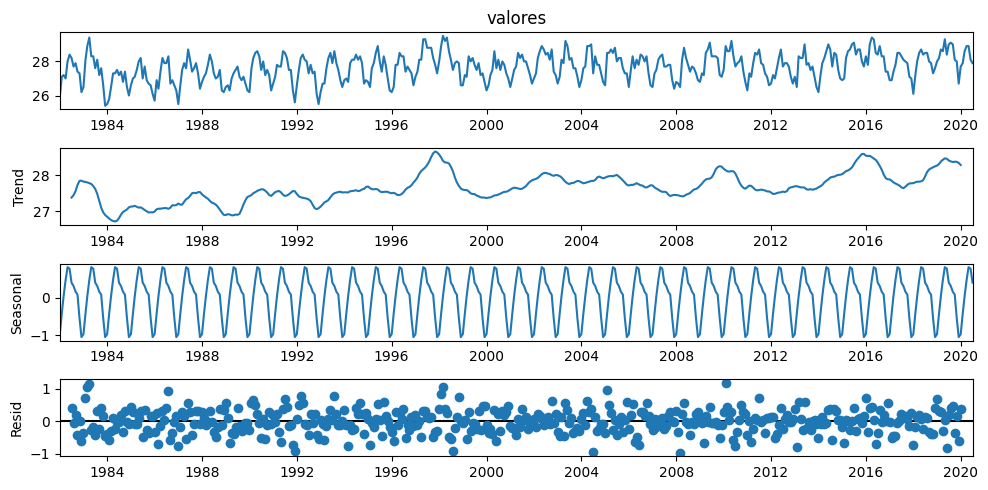

In [13]:
res = seasonal_decompose(df.valores, model="additive")
res.plot();

## Estacionalidad


Un patr√≥n estacional se produce cuando una serie temporal se ve afectada por factores estacionales, como la √©poca del a√±o o el d√≠a de la semana. La estacionalidad tiene siempre una frecuencia fija y conocida.



In [14]:
df2 = df.copy()
df2.head()

valores
month              
1982-01-01     25.9
1982-02-01     27.1
1982-03-01     27.2
1982-04-01     27.0
1982-05-01     28.0

In [15]:
df2["year"] = df2.index.year
df2["month"] = df2.index.month
df2.head()

valores  year  month
month                           
1982-01-01     25.9  1982      1
1982-02-01     27.1  1982      2
1982-03-01     27.2  1982      3
1982-04-01     27.0  1982      4
1982-05-01     28.0  1982      5

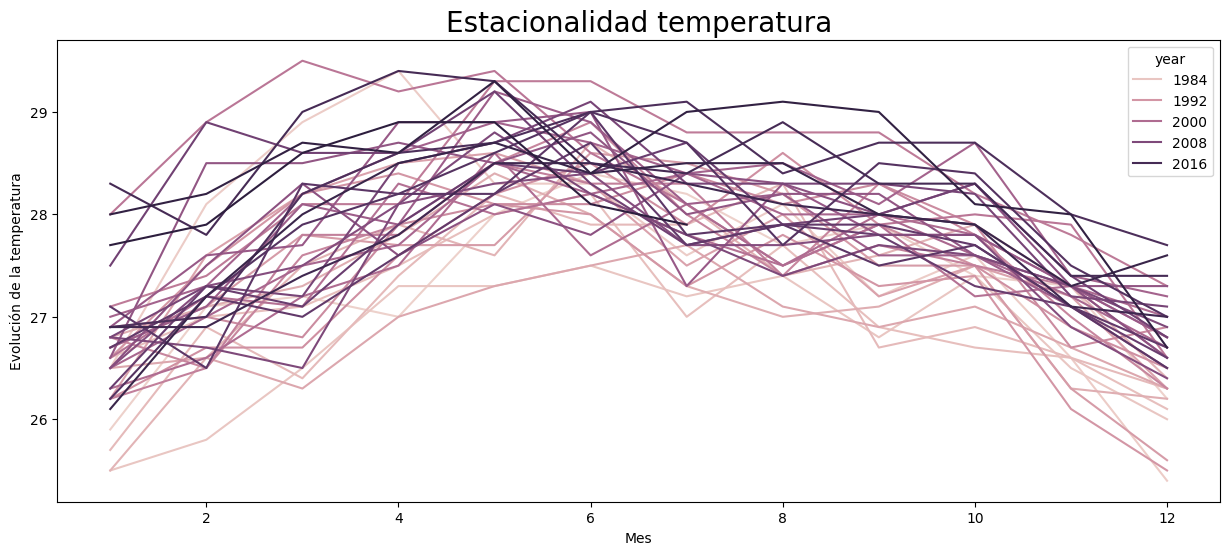

In [16]:
fig, ax = plt.subplots(figsize=(15, 6))

sns.lineplot(x = 'month',  y = 'valores', hue=df2['year'], data = df2)
ax.set_title('Estacionalidad temperatura', fontsize = 20, loc='center')
ax.set_xlabel('Mes')
ax.set_ylabel('Evoluci√≥n de la temperatura');

## Estacionaridad

Existe una tendencia cuando hay un aumento o una disminuci√≥n a largo plazo en los datos. No tiene por qu√© ser lineal. A veces se dice que una tendencia "cambia de direcci√≥n" cuando puede pasar de una tendencia creciente a una tendencia decreciente. Se puede decir que una serie es estacionaria cuando **su media y su varianza no est√°n en funci√≥n del tiempo**, es decir, son constantes en el tiempo.

La estacionariedad es importante porque la mayor√≠a de los m√©todos estad√≠sticos para realizar an√°lisis y predicciones se basan en la suposici√≥n de que las propiedades estad√≠sticas de la serie (media, varianza, correlaci√≥n, etc.) son constantes en el tiempo.

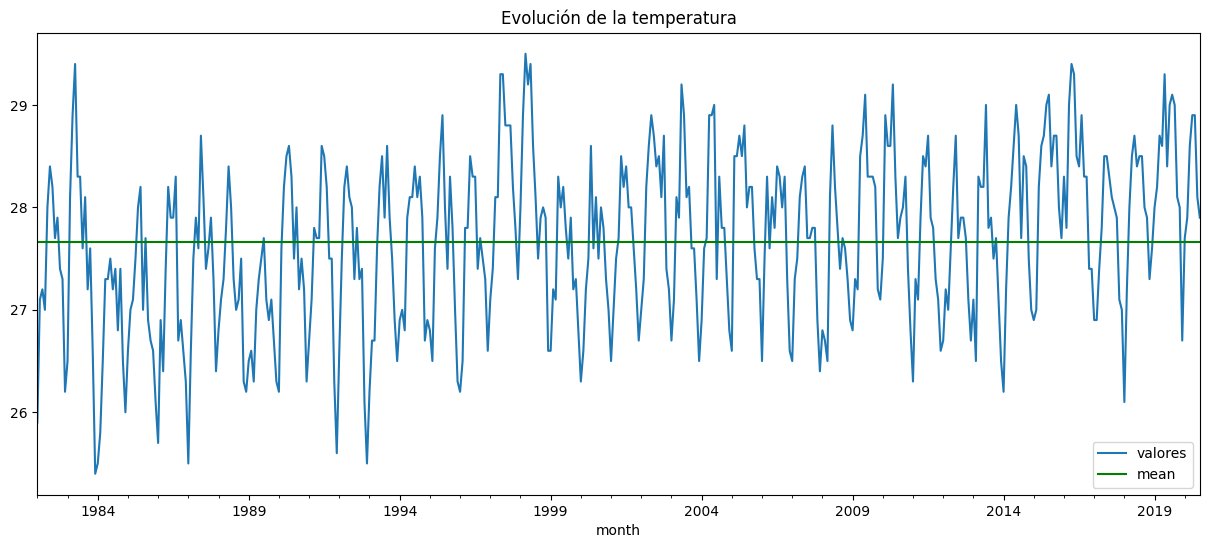

In [17]:
df.plot(figsize=(15,6))
plt.title("Evoluci√≥n de la temperatura")
plt.axhline(df.valores.mean(), c="g", label="mean")
plt.legend();


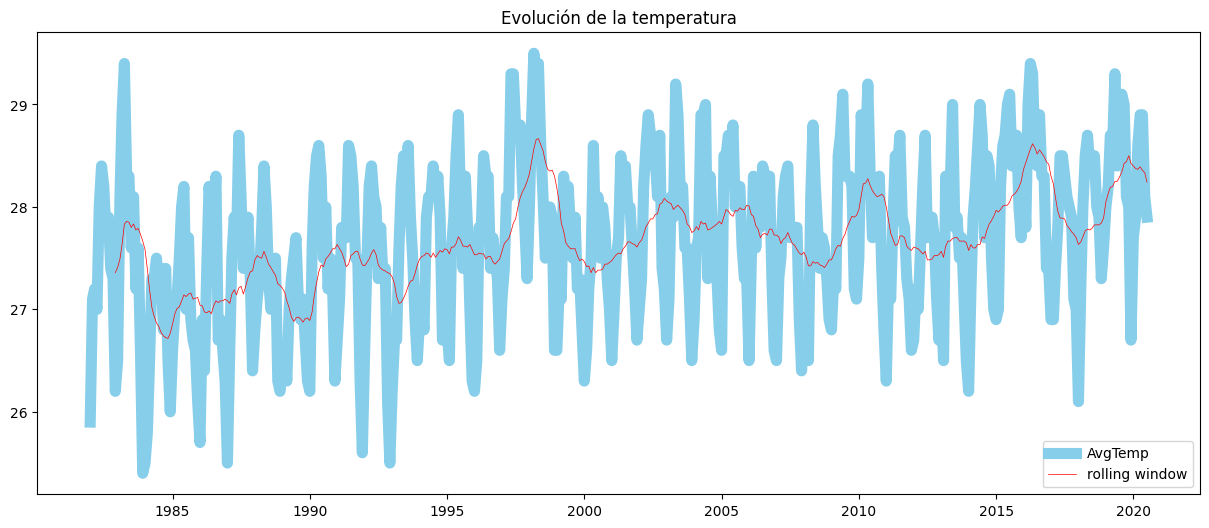

In [18]:
plt.figure(figsize=(15,6))
plt.title("Evoluci√≥n de la temperatura")

plt.plot(df["valores"], label="AvgTemp", linewidth=8, c = "skyblue")
plt.plot(df.rolling(window = 12).mean(), label="rolling window", c= "r", linewidth = 0.5)

plt.legend();

Al plotear la media junto con los puntos de datos originales, podemos ver que son  algo constantes en el tiempo, no vemos ninguna tendencia de incremento o disminuci√≥n. Sin embargo, parecen seguir un comportamiento. c√≠clico. Pero esto nos puede convencer poco, tambi√©n podemos hacer el test de ADFuller

In [19]:
res_ad = adfuller(df["valores"])
res_ad

(-4.3683613705968956,
 0.0003375321830770895,
 18,
 444,
 {'1%': -3.4451642100030084,
  '5%': -2.8680716196949327,
  '10%': -2.5702491139112085},
 572.4644501818075)

In [20]:
# pongamosle etiquetas a los resultados
print('ADF Statistic:', res_ad[0])
print('p-value:', res_ad[1])
print('Critical Values:')
for key, value in res_ad[4].items():
    print( "\t",  key, round(value, 2))

ADF Statistic: -4.3683613705968956
p-value: 0.0003375321830770895
Critical Values:
	 1% -3.45
	 5% -2.87
	 10% -2.57


¬øCu√°les son las conclusiones de esta prueba?

A partir de los resultados del test de Dickey Fuller podemos observar dos cosas:

- Si adf > valores_cr√≠ticos  ==> DATOS NO ESTACIONARIOS

- pvalue> 0.05  ==> DATOS NO ESTACIONARIOS

En nuestro caso, nuestros datos son estacionarios! 

## Comparativa estacionalidad vs estacionaridad

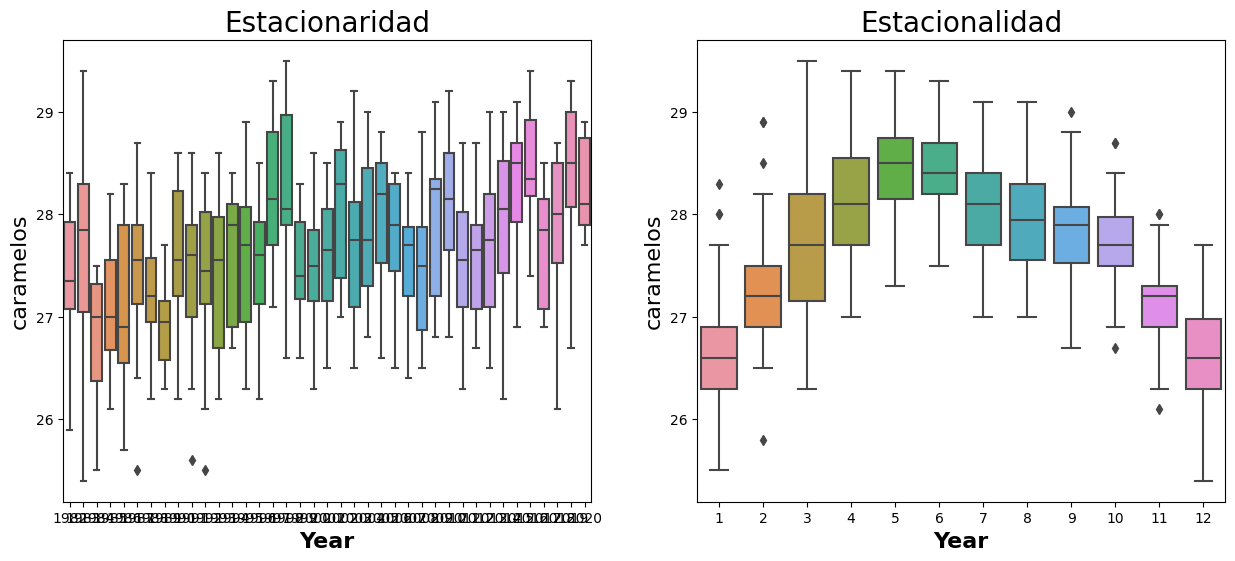

In [21]:
# nos creamos una lista con las columnas de tiempo
tiempo = df2.columns.drop("valores")

componentes = ["Estacionaridad", "Estacionalidad"]

#iniciamos los subplots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# hacemos nuestro for para no repetir lineas de c√≥digo
for i, col in enumerate(tiempo):
    sns.boxplot(x = df2[col], y = df2["valores"], ax=ax[i])
    ax[i].set_title(componentes[i], fontsize = 20, loc='center')
    ax[i].set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
    ax[i].set_ylabel('caramelos', fontsize = 16)
plt.show()

# Autocorrelaci√≥n

La autocorrelaci√≥n es un tipo de dependencia temporal. En concreto, la autocorrelaci√≥n se produce cuando una serie temporal est√° relacionada linealmente con una versi√≥n retardada de la misma. 

**Se trata de una medida de la correlaci√≥n de los datos de la serie temporal en un momento dado con los valores pasados, lo que tiene enormes implicaciones en muchos sectores. Por ejemplo, si nuestros datos de ventas de caramelos tienen una fuerte autocorrelaci√≥n, podemos suponer que un n√∫mero elevado de ventas hoy sugiere una fuerte probabilidad de que tambi√©n sea elevado ma√±ana**


Quiz√°s el aspecto m√°s convincente del an√°lisis de autocorrelaci√≥n es c√≥mo puede ayudarnos a descubrir patrones ocultos en nuestros datos y a seleccionar los m√©todos de previsi√≥n correctos. En concreto, podemos utilizarlo para ayudar a identificar la estacionalidad y la tendencia en nuestros datos de series temporales. Adem√°s, el an√°lisis conjunto de la funci√≥n de autocorrelaci√≥n (ACF) y la funci√≥n de autocorrelaci√≥n parcial (PACF) es necesario para seleccionar el modelo ARIMA adecuado para la predicci√≥n de series temporales.

- `Auto-correlaci√≥n`: la correlaci√≥n entre dos momentos/instantes de tiempo.


- `Auto-correlaci√≥n parcial`: es una medida de la correlaci√≥n entre observaciones de una serie de tiempo que se encuentran separadas por k unidades de tiempo (yt y yt-k), despu√©s de ajustarse para la presencia de los dem√°s t√©rminos de desfase m√°s corto (yt-1, yt-2, ..., yt‚Äìk‚Äì1).

![auto](https://github.com/Ironhack-Part-Time-Enero2022/apuntes-clases/blob/master/semana-20/imagenes/autocorrelation-anatomy-python.jpg?raw=true)

In [22]:
# evaluemos la autocorrelaci√≥n
for i in range(20):
    print(f"{i} mes Lag: ", df['valores'].autocorr(lag=i))

0 mes Lag:  1.0
1 mes Lag:  0.7230976534612946
2 mes Lag:  0.4564015612394833
3 mes Lag:  0.16726948619310658
4 mes Lag:  -0.056569870839973474
5 mes Lag:  -0.20708869349842243
6 mes Lag:  -0.23506213283039426
7 mes Lag:  -0.18591221141271785
8 mes Lag:  -0.05524756614084002
9 mes Lag:  0.11148078934744748
10 mes Lag:  0.34044115096052513
11 mes Lag:  0.5448761604069142
12 mes Lag:  0.6542048276244479
13 mes Lag:  0.5235635613127931
14 mes Lag:  0.2920808865550884
15 mes Lag:  0.03943547096521894
16 mes Lag:  -0.1613563570935575
17 mes Lag:  -0.3231699799160958
18 mes Lag:  -0.35956506377112274
19 mes Lag:  -0.3378846358267866


Veamoslo visualmente, los gr√°ficos generados a partir de estas funciones se denominan correlogramas, los cuales contienen bandas con un intervalo de confianza del 95%.

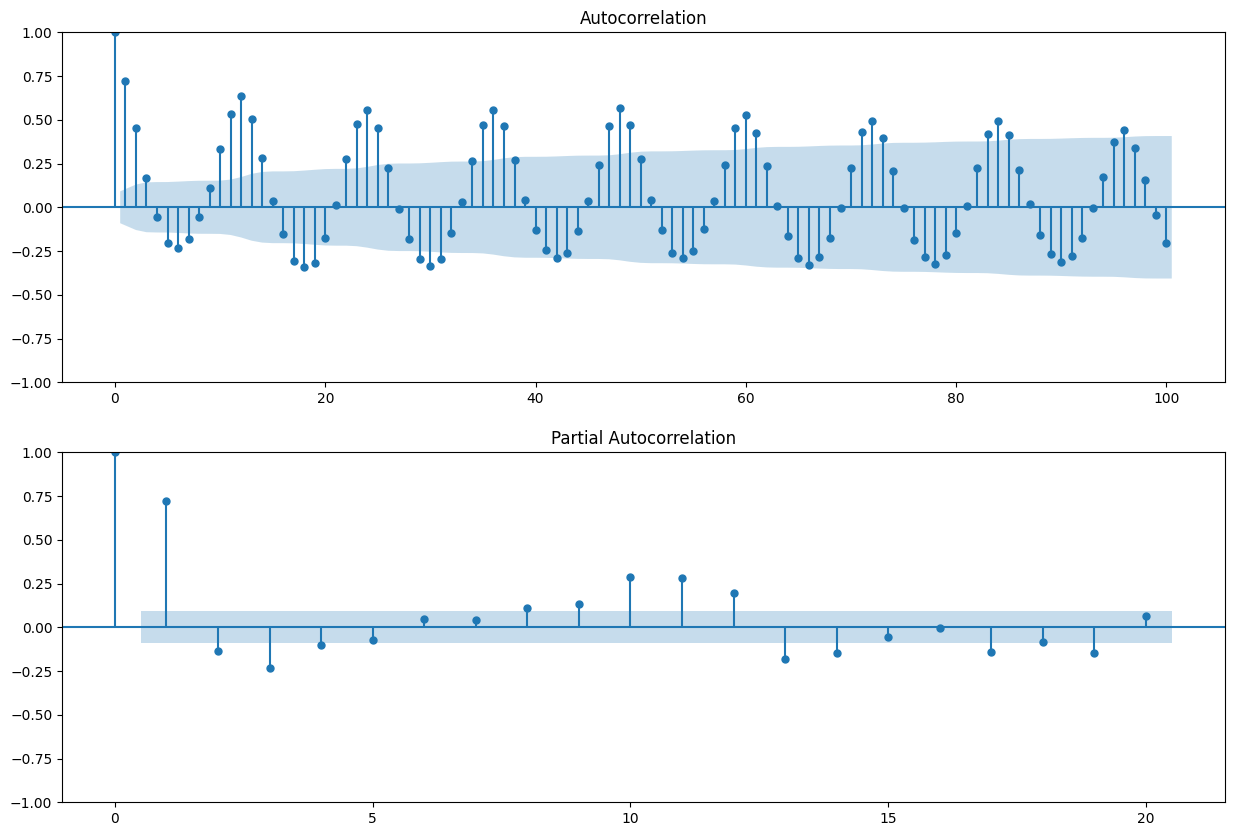

In [23]:
fig, axes = plt.subplots(2, 1, figsize=(15,10))
plot_acf(df, lags=100, ax= axes[0])
plot_pacf(df, lags=20, ax= axes[1]);

# Modelo ARMA

El modelo ARMA, del ingl√©s, *AutoRegressive Moving Average* se divide en dos partes:

- `Autorregresivo(AR)`: la variable dependiente depende de s√≠ misma en un per√≠odo de tiempo t. **Ser√° la `p` y lo sacaremos de la gr√°fica de autocorrelaci√≥n**. En otras palabras, el modelo autorregresivo se basa en la idea de que la observaci√≥n actual puede explicarse con valores pasados. Estos modelos se denotan como AR(p) siendo p el n√∫mero de muestras que explican la muestra actual. Es decir, un AR(1) quiere decir que s√≥lo la muestra anterior y el ruido contribuye a la salida. Un AR(2) las dos anteriores y el ruido, etc. 


- `Media m√≥vil(MA)`: los retrocesos son representados por procesos aleatorios. **Ser√° la `q` y lo sacaremos de la gr√°fica de autocorrelaci√≥n parcial**. Es decir, consiste en realizar una aproximaci√≥n a la serie utilizando √∫nicamente ruido blanco. Por ejemplo, los √≥rdenes de media m√≥vil de 2 especifican que las desviaciones respecto al valor medio de la serie de cada uno de los dos √∫ltimos per√≠odos de tiempo se tienen en cuenta al predecir los valores actuales de la serie.


Juntando ambos t√©rminos obtenemos los modelos ARMA (p,q), los cu√°les determinan la serie en funci√≥n su pasado hasta el retardo p, del ruido actual y el pasado del ruido hasta el retardo q. Hemos comentado anteriormente que lo que no consigui√©semos modelar de forma estacionaria ser√≠a ruido blanco. 

> la d es el n√∫mero de diferencias no estacionales. En este caso SIEMPRE SER√Å 0. 


Lo primero que tenemos que hacer es separar nuestros datos en *train* y *test*, para seguir con buenas pr√°cticas y ver si nuestras predicciones est√°n *overfiteadas* 

In [24]:
y_test = df["valores"][-30:]
y_train = df["valores"][:-30]

In [54]:
ps = range(4)
qs = range(6)

parameters = list(product(ps, qs))
print(parameters)

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5)]


In [55]:
%%time
rmse = []
order = []
for p,q in tqdm(parameters):
    try:
        modelo=ARIMA(y_train, order=(p, 0, q)).fit()
        pred = modelo.predict(start=len(y_train), end=len(df) -1)
        error = np.sqrt(np.mean(mean_squared_error(y_test, pred)))
        rmse.append(error)
        order.append((p,q))
    except: 
        continue

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 24/24 [00:03<00:00,  7.37it/s]

CPU times: user 15.6 s, sys: 1.04 s, total: 16.6 s
Wall time: 3.26 s


In [56]:
results = pd.DataFrame({"RMSE": rmse, "order": order})
results.sort_values(by="RMSE", inplace=True, ascending = True)
results.head()

RMSE   order
20  0.715676  (3, 2)
16  0.766011  (2, 4)
22  0.769156  (3, 4)
15  0.771354  (2, 3)
10  0.803423  (1, 4)

In [57]:
# fiteamos el modelo con los valores obtenidos de la tabla anterior y predecimos

modelo=ARIMA(y_train, order=(3, 0, 2)).fit()
pred = pd.DataFrame(modelo.predict(start=len(y_train), end=len(df) -1))

In [58]:
fecha = pd.date_range("2018-02-01", periods=30, freq="MS")
fecha

DatetimeIndex(['2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
               '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
               '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01',
               '2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01',
               '2019-06-01', '2019-07-01', '2019-08-01', '2019-09-01',
               '2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01'],
              dtype='datetime64[ns]', freq='MS')

In [59]:
pred.index = fecha

In [60]:
pred.head()

predicted_mean
2018-02-01       26.690520
2018-03-01       27.294017
2018-04-01       27.841600
2018-05-01       28.244687
2018-06-01       28.432295

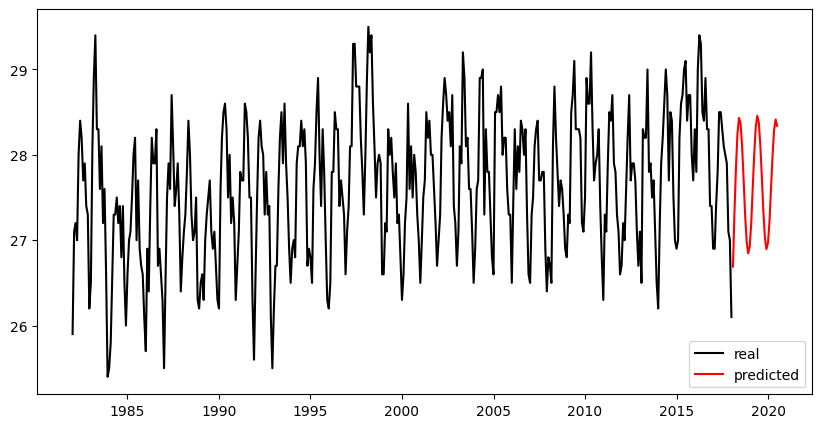

In [61]:
# veamos graficamente las predicciones
plt.plot(y_train, c = "black")
plt.plot(pred, c = "r")
plt.legend(["real", "predicted"]);

In [62]:
# a√±adimos al df de las predicciones los valores reales para compararlos con los predichos
pred["real"] = y_test

In [63]:
pred.head()

predicted_mean  real
2018-02-01       26.690520  27.2
2018-03-01       27.294017  28.0
2018-04-01       27.841600  28.5
2018-05-01       28.244687  28.7
2018-06-01       28.432295  28.4

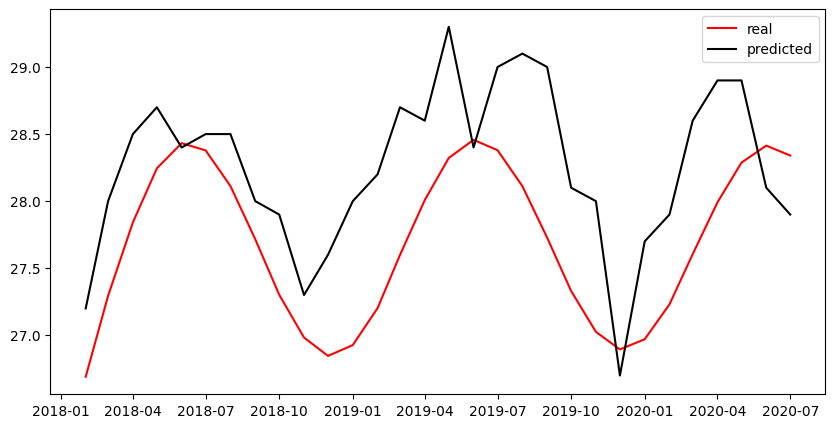

In [64]:
plt.plot(pred['predicted_mean'], c = "r")
plt.plot(pred["real"], c = "black")
plt.legend(["real", "predicted"]);

**Vamos a hacer predicciones m√°s all√° de los datos que tenemos, en concreto intentaremos predecir los siguientes doce meses**

In [65]:
fecha2 = pd.date_range("2020-07-01", periods=12, freq="MS")
fecha2

DatetimeIndex(['2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01', '2021-01-01', '2021-02-01',
               '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01'],
              dtype='datetime64[ns]', freq='MS')

In [66]:
pred2 = pd.DataFrame(modelo.predict(start=len(df) , end=len(df)  + 12))

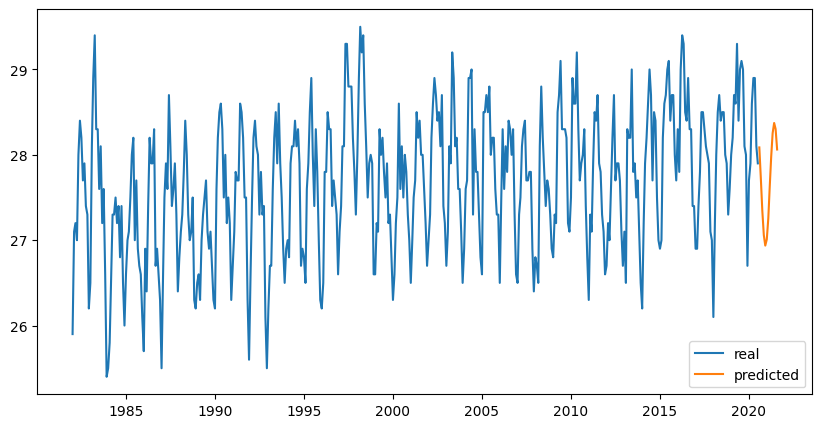

In [67]:
# ploteamos los resultados

plt.plot(df)
plt.plot(pred2)
plt.legend(["real", "predicted"]);

In [68]:
df2 = df[df.index.year > 2017]
df2.head()

valores
month              
2018-01-01     26.1
2018-02-01     27.2
2018-03-01     28.0
2018-04-01     28.5
2018-05-01     28.7

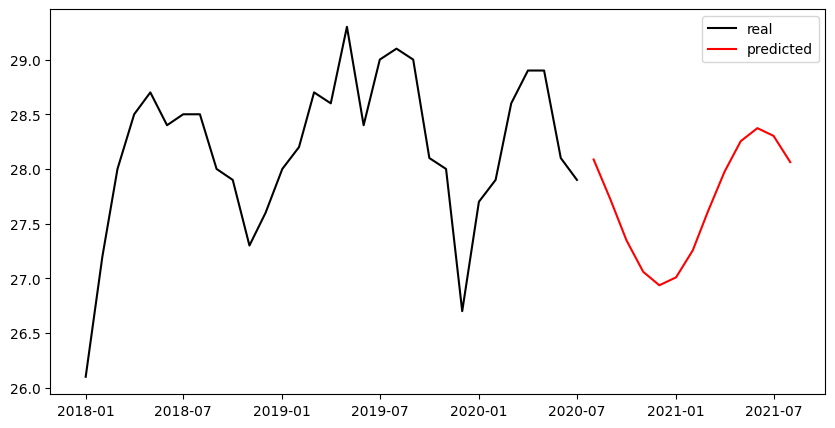

In [69]:
plt.plot(df2, c = "black")
plt.plot(pred2, c = "r")
plt.legend(["real", "predicted"]);